In [ ]:
import numpy as np
import os
import glob 
import time 
import pandas as pd
import shutil
import re
import mdtraj as md
import MDAnalysis as mda
import pickle
import pickle as p 
import csv
import sys
import subprocess
import xml.etree.ElementTree as ET
import requests
import concurrent.futures
import multiprocessing
import nglview as nv
import h5py
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches
import html
import biobox as bb
import tempfile
import matplotlib.pyplot as plt
import molearn
import torch
import glob as glob
import MDAnalysis.analysis.rms as rms
import seaborn as sns
import pickle
import networkx as nx
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir),'src'))

from Bio import PDB
from tqdm import tqdm
from time import time as t
from urllib.request import urlretrieve as download
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Blast.Applications import NcbipsiblastCommandline
from collections import defaultdict
from Bio.PDB import PPBuilder
from Bio.SeqUtils import seq1
from modeller import *
from modeller.automodel import *
from Bio.PDB import PDBParser
from MDAnalysis.analysis import align
from mpi4py import MPI
from glob import glob
from pprint import pprint as pp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob as g
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib.ticker import FuncFormatter
from collections import defaultdict
from pymol import cmd
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from scipy import stats
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from matplotlib.colors import BoundaryNorm
from numpy.linalg import norm
from molearn.data import PDBData
from molearn.trainers import Trainer
from molearn.models.small_foldingnet import Small_AutoEncoder
from molearn.analysis.analyser import MolearnAnalysis
from copy import deepcopy
from molearn.analysis import MolearnGUI
from scipy.ndimage import rotate
from numpy.linalg import inv
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from itertools import combinations
from urllib.request import urlretrieve
from urllib.error import URLError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
from scipy.stats import pearsonr


/root/miniconda3/envs/braf-work/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


/root/miniconda3/envs/braf-work/lib/python3.10/site-packages/molearn/trainers/sinkhorn_trainer.py:13: UserWarning: No module named 'geomloss'. Will not be able to use sinkhorn because geomloss is not installed.
  warnings.warn(f'{e}. Will not be able to use sinkhorn because geomloss is not installed.')
/root/miniconda3/envs/braf-work/lib/python3.10/site-packages/molearn/scoring/__init__.py:26: UserWarning: No module named 'iotbx'. Will not be able to calculate Ramachandran score.
  warnings.warn(f"{e}. Will not be able to calculate Ramachandran score.")


Code for aligning the ends of the activation loop through PYMOL. Herethe fully reconstructed loops are used to align.

In [ ]:
"""
This script identifies DFG and APE motifs in PDB structures, ensuring APE appears after DFG to define valid activation loop boundaries. It extracts corresponding residue numbers, creates PyMOL selections, aligns structures, and calculates RMSD before and after alignment. Structures failing this motif order are skipped.
"""
def find_ape_after_dfg(seq, dfg_end_index):
    # This function ensures APE comes after DFG in the sequence
    current_index = 0
    first_ape = seq.find("APE", current_index)
    has_wrong_ape = False

    while first_ape != -1:
        # Only return the first APE that appears after the DFG motif
        if first_ape > dfg_end_index:
            return (first_ape, first_ape + 3), has_wrong_ape
        else:
            has_wrong_ape = True
            current_index = first_ape + 1
            first_ape = seq.find("APE", current_index)

    return None, has_wrong_ape

def extract_sequence_and_residue_numbers(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('PDB', pdb_file)
    
    for model in structure:
        for chain in model:
            ppb = PPBuilder()
            sequence = ''
            residue_numbers = []
            
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
                # Get the actual residue numbers from the PDB
                for residue in pp:
                    residue_numbers.append(residue.get_id()[1])  # residue.get_id()[1] gives the residue number
            print(residue_numbers)
            return str(sequence), residue_numbers
    return None, None

def find_motif_indices(seq, motif):
    index = seq.find(motif)
    if index == -1:
        return None
    return index, index + len(motif)

def print_residues_in_selection(selection_name):
    model = cmd.get_model(selection_name)
    print(model)
    residues = set((atom.resi, atom.resn) for atom in model.atom)
    print(residues)
    print(f"Residues in {selection_name}: {sorted(residues)}")

def process_structure(pdb_file, ref_name="6UAN_chainD"):
    pdb_code = os.path.basename(pdb_file).split('.')[0]
    cmd.load(pdb_file, pdb_code)

    # Extract sequence and PDB residue numbers
    seq, residue_numbers = extract_sequence_and_residue_numbers(pdb_file)
    if seq is None or residue_numbers is None:
        print(f"Skipping {pdb_code} due to inability to extract sequence and residue numbers.")
        return
    print(f"Sequence for {pdb_code}: {seq}")
    print(f"Residue numbers: {residue_numbers}")

    # Locate DFG and APE motifs
    dfg_indices = find_motif_indices(seq, "DFG")
    # Replace standard APE search with stricter logic that ensures APE is after DFG
    ape_indices, wrong_ape_first = find_ape_after_dfg(seq, dfg_indices[1])
    print(f"DFG sequence indices: {dfg_indices}")
    print(f"APE sequence indices: {ape_indices}")

    if not dfg_indices or not ape_indices:
        print(f"Skipping {pdb_code} due to missing motifs.")
        return

    # Map sequence indices to actual PDB residue numbers
    dfg_pdb_residues = [residue_numbers[i] for i in range(dfg_indices[0], dfg_indices[1])]
    ape_pdb_residues = [residue_numbers[i] for i in range(ape_indices[0], ape_indices[1])]
    
    print(f"DFG PDB residue numbers: {dfg_pdb_residues}")
    print(f"APE PDB residue numbers: {ape_pdb_residues}")
    print(pdb_code)
    
    # Create selections for PyMOL alignment
    cmd.select(f"{pdb_code}_dfg_selection", f"{pdb_code} and resi {dfg_pdb_residues[0]}-{dfg_pdb_residues[-1]} and name CA and not alt B+C+D")
    cmd.select(f"{pdb_code}_ape_selection", f"{pdb_code} and resi {ape_pdb_residues[0]}-{ape_pdb_residues[-1]} and name CA and not alt B+C+D")
    cmd.select(f"{pdb_code}_ends_selection", f"{pdb_code} and (resi {dfg_pdb_residues[0]}-{dfg_pdb_residues[-1]} or resi {ape_pdb_residues[0]}-{ape_pdb_residues[-1]}) and name CA and not alt B+C+D")

    # Print which residues are selected
    print_residues_in_selection(f"{pdb_code}_dfg_selection")
    print_residues_in_selection(f"{pdb_code}_ape_selection")
    print_residues_in_selection(f"{pdb_code}_ends_selection")

    # RMSD before alignment
    rms_dfg_before = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_before = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_before = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"Before alignment RMSD for {pdb_code}: DFG={rms_dfg_before}, APE={rms_ape_before}, ENDS={rms_ends_before}")

    # Align to reference structure using end-region selection (DFG+APE)
    cmd.align(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", cycles=0, transform=1)

    aligned_pdb_path = os.path.join(output_dir, f"{pdb_code}_aligned.pdb")
    cmd.save(aligned_pdb_path, pdb_code)
    print(f"Saved aligned structure to {aligned_pdb_path}")

    # RMSD after alignment
    rms_dfg_after = cmd.rms_cur(f"{pdb_code}_dfg_selection", f"{ref_name}_dfg_selection", matchmaker=-1)
    rms_ape_after = cmd.rms_cur(f"{pdb_code}_ape_selection", f"{ref_name}_ape_selection", matchmaker=-1)
    rms_ends_after = cmd.rms_cur(f"{pdb_code}_ends_selection", f"{ref_name}_ends_selection", matchmaker=-1)

    print(f"After alignment RMSD for {pdb_code}: DFG={rms_dfg_after}, APE={rms_ape_after}, ENDS={rms_ends_after}")
    cmd.delete(f"{pdb_code}_dfg_selection")
    cmd.delete(f"{pdb_code}_ape_selection")
    cmd.delete(f"{pdb_code}_ends_selection")
    cmd.delete(pdb_code)

In [ ]:
"""
This script aligns structures based on the DFG and APE motifs. It first defines DFG and APE regions in the reference structure, ensures APE comes after DFG in each target structure, then aligns the selected regions and saves the aligned PDBs. RMSD values before and after alignment are recorded for evaluation.
"""

import sys
from pymol import cmd
from glob import glob
import os
from Bio.PDB import PDBParser, PPBuilder

#Define file paths
pdb_dir = "Results/activation_segments/reconstructedModeller/"
reference_pdb = "6UAN_chainD.pdb"
output_dir = "Results/activation_segments/reconstructed_ends_aligned_new/"

os.makedirs(output_dir, exist_ok=True)

cmd.load(reference_pdb, "6UAN_chainD")

#Redirect standard output to a log file for RMSD information
sys.stdout = open("RMSD_new.txt", "w", encoding="utf-8") 

# Extract sequence and residue numbers from the reference structure 
ref_seq, ref_residue_numbers = extract_sequence_and_residue_numbers(reference_pdb)
if ref_seq and ref_residue_numbers:
    # Find motif positions (index in sequence) for DFG and APE
    ref_dfg_indices = find_motif_indices(ref_seq, "DFG")
    ref_ape_indices = find_motif_indices(ref_seq, "APE")
    
    if ref_dfg_indices and ref_ape_indices:
        # Map motif indices to actual residue numbers in PDB
        ref_dfg_pdb_residues = [ref_residue_numbers[i] for i in range(ref_dfg_indices[0], ref_dfg_indices[1])]
        ref_ape_pdb_residues = [ref_residue_numbers[i] for i in range(ref_ape_indices[0], ref_ape_indices[1])]
        
        print(f"Reference DFG PDB residue numbers: {ref_dfg_pdb_residues}")
        print(f"Reference APE PDB residue numbers: {ref_ape_pdb_residues}")
        
        #Create PyMOL selections for DFG, APE, and combined ends region
        cmd.select("6UAN_chainD_dfg_selection", f"6UAN_chainD and resi {ref_dfg_pdb_residues[0]}-{ref_dfg_pdb_residues[-1]} and name CA")
        cmd.select("6UAN_chainD_ape_selection", f"6UAN_chainD and resi {ref_ape_pdb_residues[0]}-{ref_ape_pdb_residues[-1]} and name CA")
        cmd.select("6UAN_chainD_ends_selection", f"6UAN_chainD and (resi {ref_dfg_pdb_residues[0]}-{ref_dfg_pdb_residues[-1]} or resi {ref_ape_pdb_residues[0]}-{ref_ape_pdb_residues[-1]}) and name CA")
        
        # Verify reference selections
        print("Reference structure selections:")
        print_residues_in_selection("6UAN_chainD_dfg_selection")
        print_residues_in_selection("6UAN_chainD_ape_selection")
        print_residues_in_selection("6UAN_chainD_ends_selection")
    else:
        # Error if DFG or APE motifs not found in reference
        print("Error: Could not find DFG or APE motifs in reference structure")
        exit()
else:
    print("Error: Could not extract sequence from reference structure")
    exit()


# Load all PDB files and process them
fps = glob(pdb_dir + "*.pdb")
for fp in fps:
    print(fp)
    process_structure(fp)


In [6]:
import re

input_file = "RMSD_new.txt"
output_file = "rmsd_detailed_summary_new.txt"

with open(input_file, 'r') as f:
    lines = f.readlines()

results = []
i = 0
while i < len(lines):
    line = lines[i]

    if line.startswith("Results/activation_segments/reconstructedModeller/"):
        pdb_line = line.strip()
        dfg_line = ""
        ape_line = ""
        rmsd_before = ""
        rmsd_after = ""

        j = 1
        while i + j < len(lines) and not lines[i + j].startswith("Results/activation_segments/reconstructedModeller/"):
            next_line = lines[i + j].strip()

            if "DFG PDB residue numbers" in next_line:
                dfg_line = next_line
            elif "APE PDB residue numbers" in next_line:
                ape_line = next_line
            elif "Before alignment RMSD" in next_line:
                rmsd_before = next_line
            elif "After alignment RMSD" in next_line:
                rmsd_after = next_line

            j += 1

        # Default to "Not found" if missing
        if not dfg_line:
            dfg_line = "DFG PDB residue numbers: Not found"
        if not ape_line:
            ape_line = "APE PDB residue numbers: Not found"
        if not rmsd_before:
            rmsd_before = "Before alignment RMSD: Not found"
        if not rmsd_after:
            rmsd_after = "After alignment RMSD: Not found"

        results.append(f"{pdb_line}\n{dfg_line}\n{ape_line}\n{rmsd_before}\n{rmsd_after}\n\n")

    i += 1

# Save output
with open(output_file, 'w') as f:
    f.writelines(results)

print(f"Extracted {len(results)} entries to {output_file}")


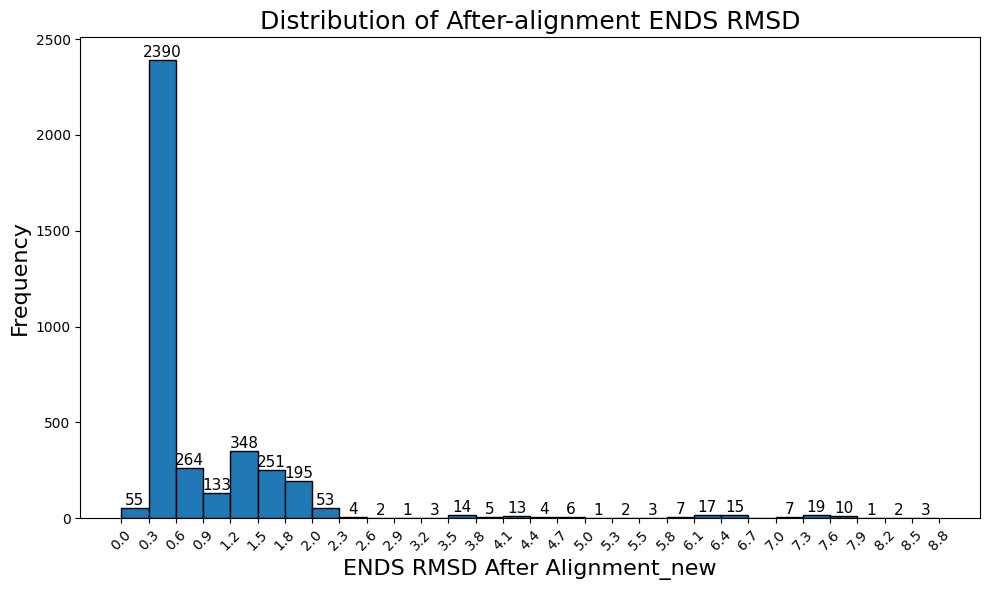

[0.00, 0.29): 55 structures
  - 1PHK_A
  - 1RE8_A_filled
  - 1XBA_A
  - 1XBC_A
  - 2GMX_A
  - 3L9M_A_filled
  - 3MVJ_E_filled
  - 3TNP_F_filled
  - 3V3V_A_filled
  - 3VF9_A
  - 3VUH_A_filled
  - 3VUI_A_filled
  - 3VUK_A_filled
  - 4AE6_B_filled
  - 4DFL_A
  - 4GV1_A_filled
  - 4I0R_A_filled
  - 4NTT_B_filled
  - 4PV0_A
  - 4WSQ_A
  - 4WSQ_B
  - 5IZJ_B_filled
  - 5LCQ_A_filled
  - 5T8P_A_filled
  - 5V60_A_filled
  - 5V62_A_filled
  - 5Y86_A_filled
  - 6BUU_B_filled
  - 6E2M_A_filled
  - 6E2N_A_filled
  - 6E2O_A_filled
  - 6ERW_A_filled
  - 6FD3_A_filled
  - 6G33_A_filled
  - 6G4Y_B
  - 6G4Z_B
  - 6H0U_A
  - 6I2H_A_filled
  - 6KYQ_B
  - 6KYR_A
  - 6KYR_B
  - 6PJJ_B_filled
  - 6Q8P_B_filled
  - 6SSB_A_filled
  - 6UAN_C
  - 6YTI_A
  - 6Z4Z_B
  - 6ZCQ_A_filled
  - 7PIG_A_filled
  - 7Q7E_A
  - 8BI2_A_filled
  - 8U8J_A_filled
  - 8UWN_A_filled
  - 8WM0_A_filled
  - 9CJ2_A_filled

[0.29, 0.58): 2390 structures
  - 1APM_E_filled
  - 1ATP_E_filled
  - 1BKX_A_filled
  - 1BX6_A_filled
  - 1CDK_A_f

In [8]:
import re
import matplotlib.pyplot as plt
import numpy as np

input_file = "rmsd_detailed_summary_new.txt"
ends_values = []
pdb_names = []

# Read ENDS RMSD values and corresponding PDB names
with open(input_file, 'r') as f:
    for line in f:
        if "After alignment RMSD" in line:
            match_ends = re.search(r"ENDS=([0-9.+eE-]+)", line)
            match_pdb = re.search(r"After alignment RMSD for (\S+):", line)
            if match_ends and match_pdb:
                ends_values.append(float(match_ends.group(1)))
                pdb_names.append(match_pdb.group(1))

# Convert lists to numpy arrays for easier indexing
ends_values = np.array(ends_values)
pdb_names = np.array(pdb_names)

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(ends_values, bins=30, edgecolor='black')

# Add frequency counts on top of each bar
for count, x in zip(n, bins[:-1]):
    if count > 0:
        ax.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=11)


# Set x-axis ticks based on bin edges
ax.set_xticks(bins)
ax.set_xticklabels([f"{b:.1f}" for b in bins], rotation=45, fontsize=10)
ax.set_xlabel("ENDS RMSD After Alignment_new", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Distribution of After-alignment ENDS RMSD", fontsize=18)
plt.tight_layout()
plt.savefig("ends_rmsd_pymol.png", dpi=300)  # 保存为高分辨率PNG图像
plt.show()

# === Group PDB names into their respective histogram bins ===
bin_structures = {}
 
for i in range(len(bins) - 1):
    bin_min = bins[i]
    bin_max = bins[i + 1]
    in_bin = (ends_values >= bin_min) & (ends_values < bin_max)
    matched_pdbs = pdb_names[in_bin]

    bin_structures[f"[{bin_min:.2f}, {bin_max:.2f})"] = list(matched_pdbs)

# Print results to terminal
for bin_range, pdbs in bin_structures.items():
    print(f"{bin_range}: {len(pdbs)} structures")
    for pdb in pdbs:
        print(f"  - {pdb}")
    print()

# Optional: Save results to a text file
with open("pdbs_by_rmsd_bins_new.txt", "w") as f:
    for bin_range, pdbs in bin_structures.items():
        f.write(f"{bin_range}: {len(pdbs)} structures\n")
        for pdb in pdbs:
            f.write(f"  - {pdb}\n")
        f.write("\n")

print("Saved binned PDB names to pdbs_by_rmsd_bins_new.txt")

# === Sort all ENDS RMSD values with PDB names in descending order ===
sorted_entries = sorted(zip(pdb_names, ends_values), key=lambda x: x[1], reverse=True)

# Save to a new text file
with open("sorted_ends_rmsd_new.txt", "w") as f:
    f.write("PDB\tENDS_RMSD\n")
    for pdb, ends in sorted_entries:
        f.write(f"{pdb}\t{ends:.6f}\n")

print("Saved sorted ENDS RMSD values to sorted_ends_rmsd_new.txt")

